In [2]:
import pandas as pd

cust_df = pd.read_csv("customers.csv")
cust_df.shape

(5000, 3)

In [3]:
# ファイル上部のレコード
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [4]:
# データの型
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

<Axes: >

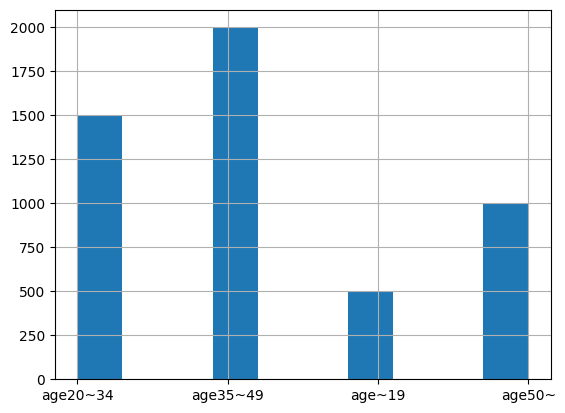

In [5]:
cust_df["age_cat"].hist()

<Axes: >

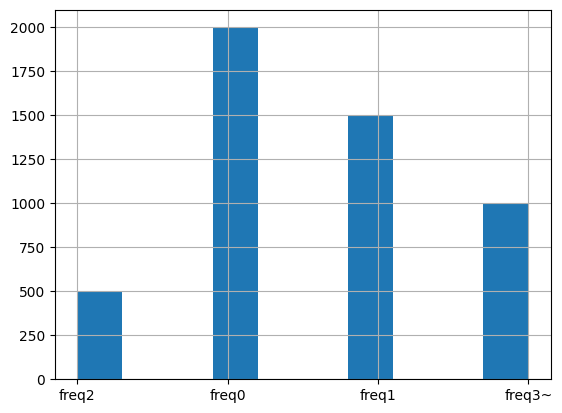

In [6]:
cust_df['freq_cat'].hist()

In [7]:
# 年齢カテゴリ × 購買頻度カテゴリごとの顧客数を集計したクロス集計表（ピボットテーブル）を作成する

# pd.pivot_table の意味：
#   data   : 元となるデータフレーム（cust_df）
#   values : 集計対象の列（ここでは 'customer_id'。個数を数えるためのダミー役）
#   index  : 行方向のカテゴリ（ここでは年齢帯 'age_cat'）
#   columns: 列方向のカテゴリ（ここでは購買頻度カテゴリ 'freq_cat'）
#   aggfunc: 集計関数（ここでは 'count' を指定して、件数（人数）を数える）
#
# 結果として得られる cust_pivot_df は、
#   行   : age_cat（例：'age~19', 'age20~34', ...）
#   列   : freq_cat（例：'low', 'mid', 'high' など）
#   要素 : その age_cat × freq_cat に属する customer_id の件数
# という「度数分布表（2 次元のクロス集計）」になる。
cust_pivot_df = pd.pivot_table(
    data=cust_df,
    values="customer_id",
    columns="freq_cat",
    index="age_cat",
    aggfunc="count",
)

# 行の並び順を明示的に指定して並べ替える処理
# reindex の目的：
#   age_cat に含まれるカテゴリの論理的な順序
#     'age~19' → 'age20~34' → 'age35~49' → 'age50~'
#   に従って行を並べ替えたい。
#
# pivot_table の時点では、行の順序は age_cat のソート順や出現順に依存するが、
# ここで reindex を使って意図した並び順を保証している。
# これにより、可視化（ヒートマップなど）やレポート出力の際に、
# 人間にとって自然な順序で年齢帯が並ぶようになる。
cust_pivot_df = cust_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])

# クロス集計結果の確認
# 行：年齢帯、列：購買頻度カテゴリ、要素：顧客数 という表になっていることを確認できる。
# この表は、後続で
#   - 行・列の合計（周辺度数）を取って全体構造を見る
#   - 割合（row-wise / column-wise）に変換して比較しやすくする
#   - ヒートマップなどで視覚化してパターンを探る
# といった分析の出発点になる。
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<Axes: xlabel='freq_cat', ylabel='age_cat'>

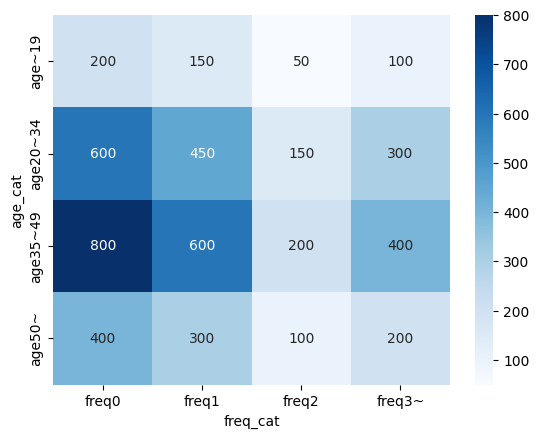

In [8]:
import seaborn as sns

sns.heatmap(cust_pivot_df, annot=True, fmt="d", cmap="Blues")

In [9]:
prob_df = pd.read_csv("visit_probability.csv")
prob_df.shape

(16, 6)

In [10]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


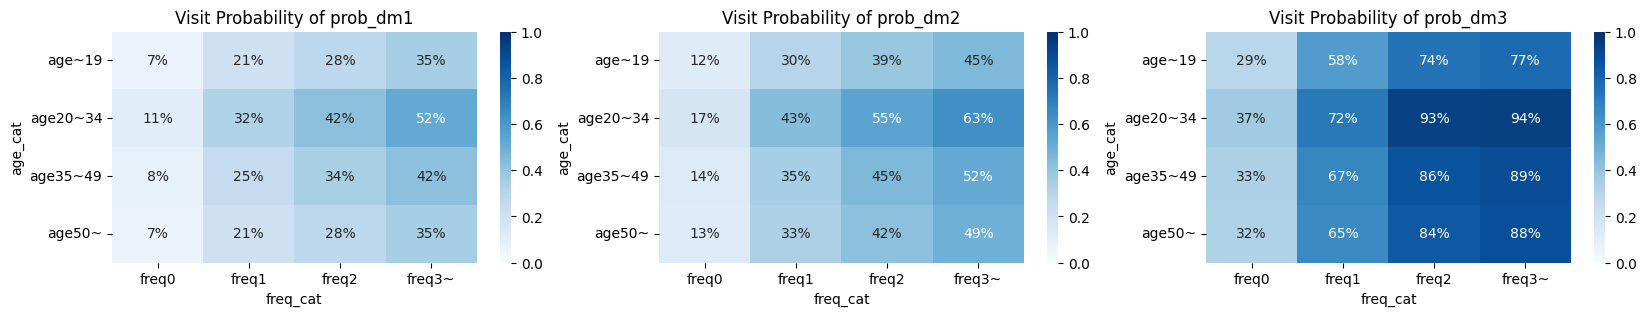

In [11]:
import matplotlib.pyplot as plt

# 複数サブプロット（横 3 枚）にアクセスしやすくするための辞書を用意
# 後で ax[0], ax[1], ax[2] という添字で軸オブジェクトを扱うために、いったん空の dict を作っておく。
ax = {}

# 1 行 3 列のサブプロットを作成
# fig : 図全体（Figure）オブジェクト
# (ax[0], ax[1], ax[2]) : 3 つの Axes オブジェクトをタプルで受け取り、同時に ax 辞書に格納している。
# figsize=(20,3) により、横長で縦を押さえたレイアウトにしている（横に 3 つ並べるため）。
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))

# 3 つの異なる訪問確率列（prob_dm1, prob_dm2, prob_dm3）について、
# 同じ形のピボットテーブル＋ヒートマップを横に並べて描画するループ
for i, ptn in enumerate(["prob_dm1", "prob_dm2", "prob_dm3"]):
    # prob_df から、age_cat（年齢カテゴリ）× freq_cat（頻度カテゴリ）ごとの
    # 「訪問確率」の平均値を集計したピボットテーブルを作成する。
    #   index  : 行方向を age_cat（例：age~19, age20~34, ...）
    #   columns: 列方向を freq_cat（例：low, mid, high など）
    #   values : 対象とする確率列（prob_dm1 / prob_dm2 / prob_dm3）
    # デフォルト aggfunc='mean' のため、「そのセルに属する顧客の平均訪問確率」が入る。
    prob_pivot_df = pd.pivot_table(
        data=prob_df, values=ptn, columns="freq_cat", index="age_cat"
    )

    # 行（年齢カテゴリ）の表示順を明示的に指定して並べ替える。
    # これにより、ヒートマップの縦方向が
    #   若年層 → 中年層 → 高年層
    # のように自然な順序になる。
    prob_pivot_df = prob_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])

    # ヒートマップを描画
    #   vmin=0, vmax=1 : カラースケールを 0〜1 に固定し、3 つの図でスケールを揃える。
    #                    これにより、確率 0.8 の「濃さ」がどの図でも同じになる。
    #   annot=True     : 各セルに数値をラベルとして表示。
    #   fmt='.0%'      : 数値をパーセント形式（小数点以下 0 桁）で表示。
    #                    例えば 0.37 なら「37%」と表示される。
    #   cmap='Blues'   : 青系のカラーマップを使用し、値が大きいほど濃い青になる。
    #   ax=ax[i]       : i 番目のサブプロット（ax[0], ax[1], ax[2]）に描画する。
    sns.heatmap(
        prob_pivot_df, vmin=0, vmax=1, annot=True, fmt=".0%", cmap="Blues", ax=ax[i]
    )

    # 各ヒートマップのタイトルを設定
    # f-string により、「Visit Probability of prob_dm1」のようなタイトルを自動生成している。
    ax[i].set_title(f"Visit Probability of {ptn}")

# レイアウトされた 3 つのヒートマップをまとめて表示
plt.show()

In [12]:
import pulp  # 線形計画問題（Linear Programming, LP）などを扱うための最適化ライブラリ PuLP をインポート

# 数理最適化モデル（線形計画問題）を定義する
# name 引数：問題の名前（ここでは「割引クーポン配布問題1」を表す識別子）
# sense 引数：目的が「最大化（LpMaximize）」か「最小化（LpMinimize）」かを指定する
#             今回はクーポン施策による「効果（例：期待売上・来店数・利益など）」を
#             最大化したいので LpMaximize を指定している。
#
# 数学的には「決定変数 x に対し、線形目的関数を最大化し、線形制約式を満たす x を求める」
# という LP（Linear Programming）を構成するスタート地点になっている。
problem = pulp.LpProblem(name="DiscountCouponProblem1", sense=pulp.LpMaximize)

In [13]:
# 会員IDのリスト
I = cust_df["customer_id"].to_list()

In [14]:
# ダイレクトメールのパターンのリスト
M = [1, 2, 3]

In [15]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定するための変数を定義
# ここで想定している集合：
#   I ：会員（顧客）集合のインデックス集合  {1, 2, ..., |I|}
#   M ：ダイレクトメール（DM）施策パターンの集合 {1, 2, ..., |M|}
#
# 数理モデルの観点では、
#   x_{i,m} = 1  … 会員 i に対して DM パターン m を送る
#   x_{i,m} = 0  … 会員 i に対して DM パターン m は送らない
# という 0–1 の意思決定変数を導入していることに相当する。
# 後続では「各会員には1つだけパターンを送る」「コスト制約」「配布数の上限」などを
# この x_{i,m} を使って線形制約として表現していく。

xim = {}  # Python 上では (i, m) をキーとする辞書で変数集合 {x_{i,m}} を表現する

for i in I:  # 全ての会員 i ∈ I について
    for m in M:  # 全ての DM パターン m ∈ M について
        # Binary を指定しているので x_{i,m} ∈ {0,1} となる。
        # name には "xim(i,m)" という文字列を与え、ソルバのログや結果を見やすくしている。
        xim[i, m] = pulp.LpVariable(name=f"xim({i},{m})", cat="Binary")

# 決定変数の総数を確認する
# 理論的には |I| × |M| 個の 0–1 変数が生成されているはずで、
# 問題規模（変数の次元）がどの程度かを把握するための簡単なチェックになっている。
len(xim)

15000

In [16]:
# （2）各会員に対して送付するダイレクトメールはいずれか 1 パターンのみ許可する制約
# 数理モデルの観点では、先に導入した 0–1 変数 x_{i,m} に対して
#
#   Σ_{m∈M} x_{i,m} = 1    （∀ i ∈ I）
#
# という制約を課していることに対応する。
# これは「会員 i について、DM パターン m の中からちょうど 1 つだけ選ぶ」という
# 排他的な選択（Exactly-one 制約）を意味する。
#
# - 左辺 Σ_{m∈M} x_{i,m} は、会員 i に対して送る DM パターンの個数を表す
#   （送るパターンの x_{i,m} が 1 になるので、その合計が「選ばれたパターン数」になる）。
# - 右辺を 1 にすることで、「0 も 2 以上も不可で、必ず 1 つだけ」に制限している。
#
# もし右辺が 0 であれば「どのパターンも送らない」、1 以上であれば
# 「複数パターンを同時に送ってもよい」という別のビジネスルールになるため、
# ここで = 1 としていることが、モデルの前提（1会員1パターン）を厳密に表現している。
for i in I:
    problem += pulp.lpSum(xim[i, m] for m in M) == 1

In [17]:
keys = ["age_cat", "freq_cat"]
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,2,age35~49,freq0,9,0.08,0.14,0.33
2,3,age35~49,freq0,9,0.08,0.14,0.33
3,4,age~19,freq0,1,0.07,0.12,0.29
4,5,age35~49,freq0,9,0.08,0.14,0.33


In [18]:
# cust_prob_df:
#   各行が顧客（customer_id）、各列 'prob_dm1', 'prob_dm2', 'prob_dm3' に
#   それぞれ DM パターンごとの来店確率が入っている「横持ち（ワイド）」なデータを想定している。

cust_prob_ver_df = (
    cust_prob_df
    # 列名 'prob_dm1', 'prob_dm2', 'prob_dm3' を、DM パターンを表す整数 1,2,3 にリネームする
    # 数理モデル側では DM パターン集合 M = {1,2,3} として扱うことが多いため、
    # ここで列名を {1,2,3} にしておくと、後続の結合や集約で「DMパターンID」として扱いやすくなる。
    .rename(columns={"prob_dm1": 1, "prob_dm2": 2, "prob_dm3": 3})
    # melt によってワイド形式 → ロング形式に変換する
    #  - id_vars=['customer_id'] は、顧客IDを「そのまま残すキー」として扱う
    #  - value_vars=[1,2,3] は、上でリネームした DMパターン列（1,2,3）を縦に「溶かす」対象とする
    #  - var_name='dm' は、元の列名（ここでは 1,2,3）を格納する列名。DMパターンIDを表す。
    #  - value_name='prob' は、元の値（確率）を格納する列名。来店確率 P(visit | customer, dm) を表す。
    #
    # 数理最適化や確率モデルの観点では、
    #   (customer_id, dm) ごとに 1 行を持つ形（ロング形式）の方が、
    #   「顧客 i に DM パターン m を送ったときの期待値」 r_{i,m} や p_{i,m} を
    #   そのままテーブル結合で参照しやすくなるため、理論モデルとの対応が取りやすい。
    .melt(
        id_vars=["customer_id"], value_vars=[1, 2, 3], var_name="dm", value_name="prob"
    )
)

cust_prob_ver_df  # 変換後のロング形式データフレームを確認

,customer_id,dm,prob
0,1,1,0.42
1,2,1,0.08
2,3,1,0.08
3,4,1,0.07
4,5,1,0.08
...,...,...,...
14995,4996,3,0.32
14996,4997,3,0.32
14997,4998,3,0.67
14998,4999,3,0.65


In [19]:
# cust_prob_ver_df は、(customer_id, dm) ごとに 1 行を持つロング形式のデータフレーム
#   customer_id : 顧客 i
#   dm          : DM パターン m（1,2,3 など）
#   prob        : 「顧客 i にパターン m を送ったときの来店確率」P(visit | i, m)
#
# set_index(['customer_id', 'dm']) によって、
#   行インデックスを (customer_id, dm) のペアにすることで、
#   「(i, m) をキーとして prob を取り出す」ための構造を作っている。
#
# その後、['prob'] で確率列だけを取り出し、to_dict() で Python の辞書に変換している。
#
# 結果として Pim は、
#   Pim[(i, m)] = P(visit | customer_id = i, dm = m)
# という形の辞書になり、数理最適化モデルでは
#
#   目的関数：max Σ_{i,m} Pim[(i,m)] * x_{i,m}
#
# のように、各顧客・各DMパターンの来店確率を係数として
# 「期待来店人数」や「期待売上（単価を掛ければ）」を線形目的関数で表現する際に使える。
Pim = cust_prob_ver_df.set_index(["customer_id", "dm"])["prob"].to_dict()

In [20]:
Pim[1, 1]

0.42

In [21]:
# （3）クーポン付与による「来客増加数（インクリメント）」を最大化する目的関数
# ここでは、dm=1 を「ベースライン施策（= 何もしない or 弱い施策）」として扱い、
# dm=2,3 を「クーポンなどの強い施策」とみなしている、という前提になっている。
#
# Pim[(i,m)] : 顧客 i に dm パターン m を送ったときの来店確率 P(visit | i, m)
# xim[i,m]   : 顧客 i に dm パターン m を送るかどうかを表す 0–1 変数
#
# ここで、顧客 i に対して dm=1 を送ったときの来店確率 Pim[(i,1)] を「基準」とみなし、
# dm=2,3 を送ったときの来店確率との差分
#
#   Pim[(i,m)] - Pim[(i,1)]
#
# を「その顧客 i に対して施策 m を採用した場合の来客“増加分”」として解釈している。
#
# 従って、目的関数
#
#   Σ_{i∈I} Σ_{m∈{2,3}} ( Pim[(i,m)] - Pim[(i,1)] ) * x_{i,m}
#
# は、全顧客・全施策について「ベースラインに対する期待来客の上乗せ分」を足し合わせた量を最大化する、
# という意味になる。このような目的は、いわゆる uplift / incremental lift を最大化する設定と整合的である。
#
# ※ dm=1 はベースラインとして必ず何か送る（あるいは「何もしない」）扱いで、
#    その上に「2 or 3 に切り替える」ことでどれだけ期待来客が増えるかを評価しているため、
#    和の中に m=1 を含めていない点が重要なモデリング上のポイント。
problem += pulp.lpSum(
    (Pim[i, m] - Pim[i, 1])
    * xim[i, m]  # 顧客 i に dm=m を選んだときのインクリメント期待値
    for i in I
    for m in [2, 3]  # ベースライン dm=1 以外（ここでは 2 と 3）だけを対象にする
)

In [22]:
Cm = {1: 0, 2: 1000, 3: 2000}

In [23]:
# （4）会員の消費する費用（クーポンコスト）の期待値の合計は 100 万円以下に制約する
#
# ここでは、次のような前提になっていると解釈できる：
#   Cm[m]        : DM パターン m を送ったときの「1来店あたりの費用（クーポン原価・割引額など）」
#   Pim[(i,m)]   : 会員 i に DM パターン m を送ったときの来店確率 P(visit | i, m)
#   xim[i,m]     : 会員 i に DM パターン m を送るかどうか（0 or 1 の決定変数）
#
# すると、顧客 i に対してパターン m を送ったときの「費用の期待値」は
#   Cm[m] * Pim[(i,m)]
# となる（1回来店したときに Cm[m] 円かかる、その来店が確率 Pim で発生する、という期待値の掛け算）。
#
# さらに、それを実際に送るかどうか（xim[i,m]）でスイッチするので、
#   Cm[m] * Pim[(i,m)] * xim[i,m]
# は
#   - xim[i,m] = 1 のとき：顧客 i に m を送った場合の「期待コスト」
#   - xim[i,m] = 0 のとき：そもそも送らないので 0
# を意味する。
#
# これを全会員 i、施策 m∈{2,3}（クーポン等の有料施策だけ）について総和を取ることで、
#   Σ_{i∈I} Σ_{m∈{2,3}} Cm[m] * Pim[(i,m)] * xim[i,m]
# という「全体としての期待費用の合計」が得られる。
#
# この左辺を 1,000,000 円（100 万円）以下に抑えるという不等式
#   Σ Cm[m] * Pim[(i,m)] * xim[i,m]  ≤ 1,000,000
# は、数理最適化的には「予算制約（budget constraint）」の一種であり、
# uplift 最大化の目的関数と組み合わせることで、
#   - 期待来客増加を最大化しつつ
#   - そのために投下するクーポン等の期待コストは 100 万円以内に抑える
# という典型的な「効果 vs コスト」のトレードオフ問題になっている。
problem += (
    pulp.lpSum(Cm[m] * Pim[i, m] * xim[i, m] for i in I for m in [2, 3]) <= 1000000
)

In [24]:
# セグメントのリスト
S = prob_df["segment_id"].to_list()
len(S)

16

In [25]:
# 各セグメントとそのセグメントに属する会員数を対応させる辞書の作成
Ns = cust_prob_df.groupby("segment_id")["customer_id"].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [26]:
# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index("customer_id")["segment_id"].to_dict()

In [27]:
# （5）各パターンのダイレクトメールを「各セグメントに属する会員数の 10%以上」に送付する制約
# --------------------------------------------------------------------
# ・S  : セグメント集合（例：年齢×来店頻度などで区切ったクラスタ）
# ・M  : DM パターン集合（例：{1, 2, 3} などの施策パターン）
# ・I  : 会員（顧客）集合
# ・Si : 会員 i がどのセグメント s に属するかを与える写像（dict など）
#        Si[i] = s で「会員 i はセグメント s に属する」ことを表す
# ・Ns : 各セグメント s に属する会員数（|{ i ∈ I : Si[i] = s }|）を表す定数
# ・xim[i,m] : 会員 i にパターン m の DM を送るなら 1、送らないなら 0 の 0–1 変数
#
# 制約の理論的な意味：
#   セグメント s ごと・パターン m ごとに
#       「その組合せに DM を受け取る会員数」 / 「そのセグメントの総会員数」
#   が 10% 以上になるように下限を課している。
#
# 数式で書くと、任意のセグメント s ∈ S とパターン m ∈ M について
#
#   Σ_{i ∈ I, Si[i] = s} x_{im}  ≥  0.1 · N_s
#
# となる。左辺は「セグメント s かつパターン m を割り当てられた会員数」、
# 右辺は「セグメント s の会員数の 10%」である。
#
# これにより：
#   - どのセグメント s に対しても、どのパターン m も “最低限は” 配信される
#   - あるセグメントで特定パターンがまったく配信されない（サンプルゼロ）状態を防げる
#   - 因果推論・A/B テスト的な観点では、各セグメント×パターンの効果を推定するための
#     最低限のサンプルサイズを確保する「探索（exploration）」制約として解釈できる
#
# 一方で、目的関数が「期待来客増加数の最大化」であるため、この 10% 下限は
#   - 純粋な “利得最大化” に対する「制約付き最適化」
#   - ビジネス的には「公平性・検証可能性・施策カバレッジ」の確保
# を数理的に表現したものになっている。

for s in S:
    # 固定したセグメント s に対して、全パターン m について下限制約を課す
    for m in M:
        problem += (
            # セグメント s に属する会員 i だけを対象に、
            # 「パターン m を送るかどうか」の 0–1 変数 xim[i,m] を合計する。
            # → セグメント s の中でパターン m を受け取る会員数になる。
            pulp.lpSum(xim[i, m] for i in I if Si[i] == s)
            # その数が、セグメント s の総会員数 Ns[s] の 10%以上であることを要求。
            # → 各セグメントに対して、各パターンの配信比率が 0.1 (10%) 以上になる。
            >= 0.1 * Ns[s]
        )

In [28]:
# 時間を計測
# モデリング1は、一部の環境ではgapRel（計算の終了判定とする上界と下界のギャップのしきい値）を指定しないと停止しない
# solver = pulp.PULP_CBC_CMD(gapRel=10e-4)

import time

time_start = time.time()
status = problem.solve()
# gapRelを指定した場合はsolve関数にて上でパラメータを指定したsolverを引数にとる
# status = problem.solve(solver)
time_stop = time.time()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/maton/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0t/6d51btm11zz6lw61fgrmf7z00000gn/T/292e304fedc04d5e8de91701eb312b21-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0t/6d51btm11zz6lw61fgrmf7z00000gn/T/292e304fedc04d5e8de91701eb312b21-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5054 COLUMNS
At line 85055 RHS
At line 90105 BOUNDS
At line 105106 ENDATA
Problem MODEL has 5049 rows, 15000 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 326.095 - 0.11 seconds
Cgl0004I processed model has 5049 rows, 15000 columns (15000 integer (15000 of which binary)) and 40000 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum -

In [29]:
print(f"ステータス:{pulp.LpStatus[status]}")
print(f"目的関数値:{pulp.value(problem.objective):.4}")
print(f"計算時間:{(time_stop - time_start):.3}(秒)")

ステータス:Optimal
目的関数値:326.1
計算時間:1.92(秒)


In [30]:
send_dm_df = pd.DataFrame(
    [[xim[i, m].value() for m in M] for i in I],
    columns=["send_dm1", "send_dm2", "send_dm3"],
)
send_dm_df.head()

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [31]:
cust_send_df = pd.concat(
    [cust_df[["customer_id", "age_cat", "freq_cat"]], send_dm_df], axis=1
)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0


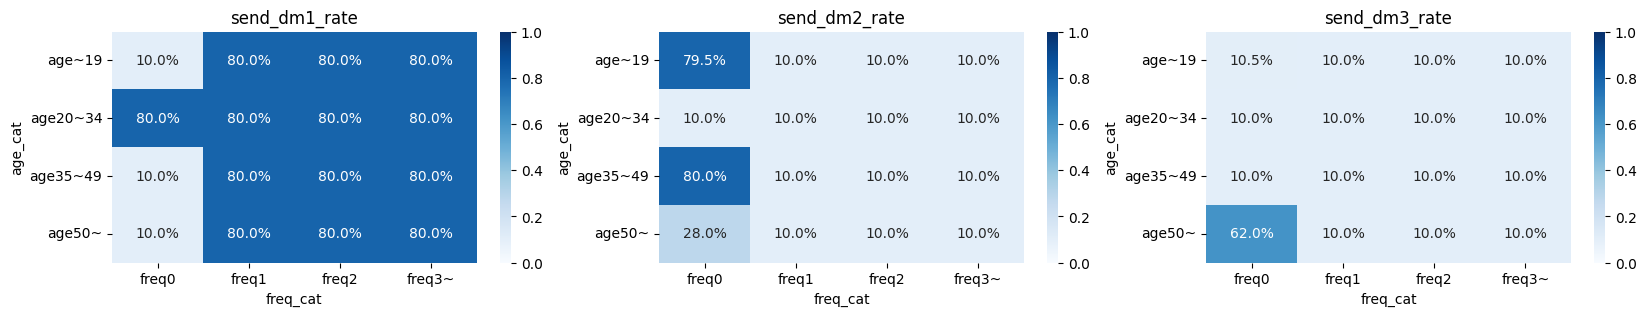

In [32]:
import matplotlib.pyplot as plt

# 各セグメント（年齢カテゴリ × 購買頻度カテゴリ）に対する
# 「どのダイレクトメールパターンをどの程度の割合で送付しているか」を
# 3 つのヒートマップで可視化するコード
#
# 理論的には：
# - send_dm1, send_dm2, send_dm3 はそれぞれ {0,1} のダミー変数（送付したら 1, 送らなければ 0）とみなせる
# - それらの平均値（aggfunc='mean'）は、そのセル（age_cat × freq_cat）における
#   「送付率（= 確率）」の推定値になっている
#   → E[send_dmX | age_cat, freq_cat] をヒートマップで描いているイメージ

ax = {}
# 1 行 3 列のサブプロットを作成し、それぞれに dm1, dm2, dm3 の送付率ヒートマップを描画する
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))

# 3 種類の DM パターンごとにループ
for i, ptn in enumerate(["send_dm1", "send_dm2", "send_dm3"]):
    # age_cat（行）× freq_cat（列）ごとに、送付ダミー変数の平均値を集計
    # ダミー変数の平均 = そのセルで DM を送った会員の割合（送付率）と解釈できる
    cust_send_pivot_df = pd.pivot_table(
        data=cust_send_df,
        values=ptn,  # 対象とする DM 送付フラグ列（0 or 1）
        columns="freq_cat",  # 列方向：購買頻度カテゴリ
        index="age_cat",  # 行方向：年齢カテゴリ
        aggfunc="mean",  # 平均値をとることで、送付率（比率）を推定
    )

    # 行（年齢カテゴリ）の並び順を明示的に指定して、グラフ上の順序を整える
    cust_send_pivot_df = cust_send_pivot_df.reindex(
        ["age~19", "age20~34", "age35~49", "age50~"]
    )

    # 送付率のヒートマップを描画
    # - vmin=0, vmax=1 にすることで、0〜100% を共通スケールで比較可能にしている
    # - fmt='.1%' によって、セル内の注釈をパーセント（小数第 1 位まで）で表示
    sns.heatmap(
        cust_send_pivot_df,
        annot=True,  # 各セルに数値（送付率）を表示
        fmt=".1%",  # パーセント表記（例： 23.4%）
        cmap="Blues",  # 色の濃さで送付率の大小を表現
        vmin=0,
        vmax=1,
        ax=ax[i],  # i 番目のサブプロットに描画
    )

    # グラフタイトルに「どの DM パターンの送付率か」を明示
    ax[i].set_title(f"{ptn}_rate")

# 全体のレイアウトを表示
plt.show()

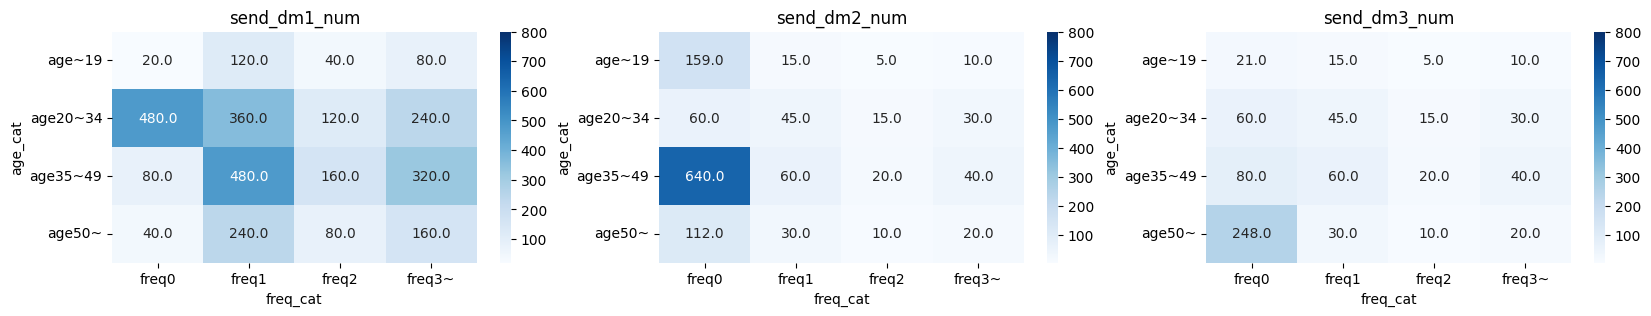

In [33]:
# 各セグメントに対するそれぞれのダイレクトメールの「送付数」を可視化するコード
# 前のコードでは aggfunc='mean' により「送付率（確率）」を見ていたが、
# ここでは aggfunc='sum' により「実際に何件送ったか」という “量（ボリューム）” を見ている。
#
# 理論的には：
# - send_dm1, send_dm2, send_dm3 は {0,1} のダミー変数（送付したら 1）とみなせる
# - その総和は、そのセル（age_cat × freq_cat）に属する会員のうち、
#   何人にその DM を送ったか、という「件数」を表す
#   → 母数（セグメントの大きさ）× 送付率 を反映した、実務上のインパクト指標

ax = {}
# 1 行 3 列のサブプロットを作成し、それぞれの DM パターンごとにヒートマップを描画
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))

# 3 種類の DM パターン（dm1, dm2, dm3）でループ
for i, ptn in enumerate(["send_dm1", "send_dm2", "send_dm3"]):
    # age_cat（行）× freq_cat（列）ごとに送付数を集計
    # - ダミー変数の合計 = そのセルで DM を送付した会員の「人数」
    cust_send_pivot_df = pd.pivot_table(
        data=cust_send_df,
        values=ptn,  # 対象とする DM 送付フラグ列（0 or 1）
        columns="freq_cat",  # 列方向：購買頻度カテゴリ
        index="age_cat",  # 行方向：年齢カテゴリ
        aggfunc="sum",  # 合計値をとることで、送付人数（件数）を算出
    )

    # 行（年齢カテゴリ）の順序を固定して、グラフの並びを見やすく整える
    cust_send_pivot_df = cust_send_pivot_df.reindex(
        ["age~19", "age20~34", "age35~49", "age50~"]
    )

    # 送付「人数（件数）」のヒートマップを描画
    # - vmax=800 はカラースケールの上限を固定し、3 つの図で比較しやすくするための設定
    # - fmt='.1f' でセル内の数値を少数 1 桁まで表示（整数でも読みやすい）
    sns.heatmap(
        cust_send_pivot_df,
        annot=True,  # 各セルに送付人数を数値表示
        fmt=".1f",  # 少数 1 桁表示（例： 123.0）
        cmap="Blues",  # 色の濃さで送付人数の大小を表現
        vmax=800,  # カラーバーの最大値（スケールを揃える）
        ax=ax[i],  # i 番目のサブプロットに描画
    )

    # タイトルに「どの DM パターンの送付数か」を明示
    ax[i].set_title(f"{ptn}_num")

# 全サブプロットをまとめて表示
plt.show()

In [34]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name="DiscountCouponProblem2", sense=pulp.LpMaximize)

In [35]:
# （1）各会員セグメント s に対して、どのパターン m のダイレクトメールを送付するかを表す変数を定義
xsm = {}

# ここでは二値（0/1）の整数変数ではなく、連続変数（実数）で [0,1] の範囲をとるように宣言している点が理論的に重要
# - lowBound=0, upBound=1 により、0 ≤ x_{s,m} ≤ 1 が課される
# - cat='Continuous' により、x_{s,m} は実数値をとることができる
#   → 解釈としては「セグメント s に属する会員のうち、どの程度の割合で DM パターン m を送るか」を表す “割合” 変数になり得る
#   → 例えば x_{s,m} = 0.3 なら、セグメント s の 30% に m を送付するポリシー、といった解釈が可能
#   → 逆に、各顧客ごとの 0/1 決定ではなく、セグメント単位の混合ポリシー（stochastic policy）を最適化するようなモデルに適している
# - この設定により、整数計画ではなく線形計画（LP）として解ける可能性が高まり、計算量の面で有利になる
#   （ただし、後段の制約次第では結局整数制約が必要になる場合もある）

for s in S:
    for m in M:
        xsm[s, m] = pulp.LpVariable(
            name=f"xsm({s},{m})",  # 変数名：識別しやすいように (セグメント s, パターン m) を埋め込んでいる
            lowBound=0,  # 下限：0（送付割合が負になることはない）
            upBound=1,  # 上限：1（送付割合は最大でも 100%）
            cat="Continuous",  # 実数値をとる連続変数として定義（0-1整数ではない点に注意）
        )

# 宣言された決定変数の総数（|S| × |M|）を確認
len(xsm)

48

In [36]:
# （2）各セグメント s に対して「送付する DM パターンの割合」が 1 になるように制約を課す
# --------------------------------------------------------------------
# ここで xsm[s,m] は「セグメント s に属する会員に対して、DM パターン m をどの程度の割合で送るか」
# を表す連続変数（0〜1）として定義されている。
#
# この制約
#     ∑_{m∈M} x_{s,m} = 1
# は、各セグメント s ごとに
#
#   - {x_{s,m}}_{m∈M} が 1 に和が揃った「確率分布」になっている
#   - つまり「セグメント s に対して、DM パターン m を送る確率（あるいは比率）」を表している
#
# という意味を持つ。
#
# 元々、顧客単位の 0–1 変数で
#   ∑_{m} x_{i,m} = 1
# とすると「各顧客 i はどれか 1 つのパターンを受け取る（排他的選択）」という意味だったが、
# ここではセグメント単位で連続値に緩和しているため、
#
#   - セグメント s に属する多数の顧客に対して、
#     「dm1 を x_{s,1} の割合」「dm2 を x_{s,2} の割合」…で送るような混合ポリシー
#
# を表現することができる。
#
# 数理最適化的には、この制約によって
#
#   - 各セグメント s に対する DM ポリシーが「単体（シンプレックス）」上の点として表現される
#   - 目的関数が線形であれば、この単体上の最適解はしばしば頂点（= 0/1 解）に来るが、
#     問題設定によっては内部点（確率的ポリシー）も最適となり得る
#
# といった性質を持つ。
#
# 実装上も、セグメントごとに「配分の総量を 100% に正規化する」役割を果たしており、
# これがないと「あるセグメントには DM を全く送らない」あるいは
# 「1 を超える割合で送る」といった、意味づけの曖昧な解が生じてしまう。

for s in S:
    # セグメント s に対する全ての DM パターン m の送付割合の総和が 1 になるように制約
    problem += pulp.lpSum(xsm[s, m] for m in M) == 1

In [37]:
# 各セグメント × DMパターンごとの来店確率を「辞書（2次元キー）」に落とし込む処理

# 1. 列名のリネーム
#   - 元の prob_df には 'prob_dm1', 'prob_dm2', 'prob_dm3' という列がある想定
#   - これを 1, 2, 3 という数値ラベルに置き換えている
#   - 後続の最適化モデルでは「DMパターン m ∈ {1,2,3}」という形で扱うため、
#     列名もそれに合わせておくと、インデックスや辞書のキーとして扱いやすくなる
prob_ver_df = prob_df.rename(
    columns={"prob_dm1": 1, "prob_dm2": 2, "prob_dm3": 3}
).melt(
    id_vars=["segment_id"],  # セグメントIDはそのまま行方向の識別子として残す
    value_vars=[1, 2, 3],  # 1,2,3 列（= DMパターンごとの確率列）を縦持ちに変換
    var_name="dm",  # 列名だった 1,2,3 を 'dm' 列の値として保持
    value_name="prob",  # 確率値を 'prob' という列名で保持
)

# melt の結果イメージ：
#   segment_id | dm | prob
#   -----------+----+------
#        s1    |  1 | P(visit | seg=s1, dm=1)
#        s1    |  2 | P(visit | seg=s1, dm=2)
#        s1    |  3 | ...
#        s2    |  1 | ...
#   のように、(segment_id, dm) ごとに 1 行になる「ロング形式」のテーブルになる

# 2. (segment_id, dm) を MultiIndex にして、その 'prob' 列だけを辞書化
#   - set_index(['segment_id','dm']) により、
#       行インデックス = (segment_id, dm) のペア
#     という MultiIndex DataFrame を作る
#   - ['prob'] で確率列を取り出し、to_dict() で
#       {(segment_id, dm): 確率} という形の dict に変換している
#   - これにより、数理最適化モデルの中で
#       Psm[s, m]
#     のような形で「セグメント s に DMパターン m を打ったときの来店確率」を
#     直接参照できるようになる
Psm = prob_ver_df.set_index(["segment_id", "dm"])["prob"].to_dict()

In [38]:
# （3）クーポン付与による来客増加数（＝ベースライン施策との差分）を最大化する目的関数を設定
# ここで考えているのは、絶対的な来店数そのものではなく、
#   「ベースライン（dm=1）を打った場合」と比べて、どれだけ来客数が増えるか
# というインクリメンタルな効果（uplift）を最大化する、という設計になっている。

# Ns[s]        : セグメント s に属する会員数（母数）
# Psm[s,m]     : セグメント s に DM パターン m を送付したときの来店確率
#                 → 確率論的には P(visit | segment=s, dm=m)
# xsm[s,m]     : 「セグメント s の会員に対して DM パターン m を送る“割合”」を表す変数
#                 - 連続変数 [0,1] なので、「セグメント内の何割に m を割り当てるか」を意味する
#                 - 各 s について Σ_m xsm[s,m] = 1 なので、セグメント単位のミックス比率になっている
#
# (Psm[s,m] - Psm[s,1]) :
#   - ベースライン施策（dm=1）に対する「来店確率の上乗せ分（uplift）」を表す
#   - m = 2,3 のときのみ考えているので、
#       m=2: P(visit | dm=2) - P(visit | dm=1)
#       m=3: P(visit | dm=3) - P(visit | dm=1)
#     となる。
#
# Ns[s] * (Psm[s,m] - Psm[s,1]) :
#   - セグメント s の全会員にパターン m を適用したとき、
#     ベースライン dm=1 に比べて「期待される来客数が何人増えるか」の期待値
#   - 期待来客数 = Ns[s] * Psm[s,m]
#     ベースライン期待来客数 = Ns[s] * Psm[s,1]
#     なので、その差が Ns[s] * (Psm[s,m] - Psm[s,1]) となる。
#
# さらに xsm[s,m] を掛けることで、
#   - セグメント s のうち xsm[s,m] 割だけを DM パターン m に割り当てたときの
#     「期待来客増加数」の寄与分を表している。
#
# 最終的に、全セグメント s と DM パターン m（ここでは 2,3）の組み合わせについて
# それぞれの「期待来客増加数」を足し合わせたものを最大化する。
# これにより、
#   - ベースライン dm=1 からどれだけ“総来客数”を上乗せできるか
# を最大化するように、セグメント×DM パターンのミックス（xsm[s,m]）を決定する、
# という線形最適化問題になっている。
problem += pulp.lpSum(
    Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3]
)